In [5]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score
from sklearn.model_selection import GridSearchCV
import joblib
from torch.utils.data import DataLoader, TensorDataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"worachotej","key":"6a42cc234064b82749f732e78beed52f"}'}

In [6]:
!mkdir -p ~/.kaggle  # Create the directory if not exists
!mv kaggle.json ~/.kaggle/  # Move the API key to the correct location
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file

# Download the dataset
!kaggle datasets download -d datasetengineer/logistics-and-supply-chain-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/datasetengineer/logistics-and-supply-chain-dataset
License(s): CC0-1.0


In [7]:
df = pd.read_csv('dynamic_supply_chain_logistics_dataset.csv')
df.drop(columns=['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude'], inplace=True)
df.head()

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [8]:
# Look if there are any duplicate rows in the dataset
df.loc[df.duplicated()]

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation


In [9]:
# Check for null values
df.isna().sum()

,0
fuel_consumption_rate,0
eta_variation_hours,0
traffic_congestion_level,0
warehouse_inventory_level,0
loading_unloading_time,0
handling_equipment_availability,0
order_fulfillment_status,0
weather_condition_severity,0
port_congestion_level,0
shipping_costs,0


In [10]:
numerical_list = [x for x in df.columns if df[x].dtype in ('int64','float64')]
print(numerical_list)

['fuel_consumption_rate', 'eta_variation_hours', 'traffic_congestion_level', 'warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability', 'order_fulfillment_status', 'weather_condition_severity', 'port_congestion_level', 'shipping_costs', 'supplier_reliability_score', 'lead_time_days', 'historical_demand', 'iot_temperature', 'cargo_condition_status', 'route_risk_level', 'customs_clearance_time', 'driver_behavior_score', 'fatigue_monitoring_score', 'disruption_likelihood_score', 'delay_probability', 'delivery_time_deviation']


In [11]:
#Removal of outlier:

df1 = df.copy()

for i in numerical_list:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
# display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))
df = df1.copy()
df.head()


Inference:
Before removal of outliers, The dataset had 32065 samples.
After removal of outliers, The dataset now has 25245 samples.


,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [12]:
# Label encoding

label_encoder = LabelEncoder()
df['risk_classification'] = label_encoder.fit_transform(df['risk_classification'])

In [13]:
# target class are highly imbalanced
df['risk_classification'].value_counts()

,count
risk_classification,
0,20451
2,4277
1,517


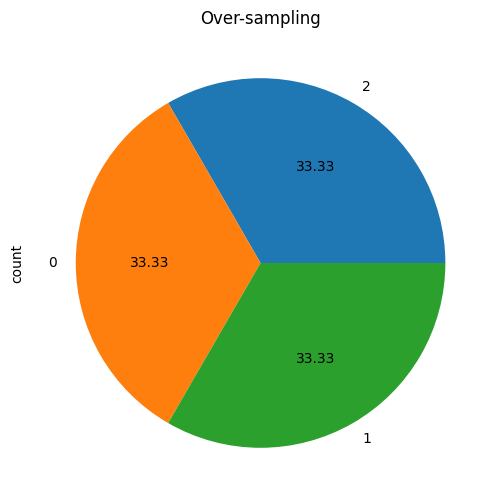

In [14]:
# solve imbalnce class

#Random Oversampling
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy="not majority") # String
# X = df.drop(['risk_classification'], axis=1)
# Y = df['risk_classification']
# X, Y = ros.fit_resample(X, Y)

# ------------------------------------------------------------

# Apply SMOTE (Synthetic Minority Over-sampling)
from imblearn.over_sampling import SMOTE
X = df.drop(columns=["risk_classification"])  # Features
Y = df["risk_classification"]  # Target
smote = SMOTE(sampling_strategy="auto", random_state=42)
X, Y = smote.fit_resample(X, Y)

ax = Y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [15]:
# after solve imbalnce class
Y.value_counts()

,count
risk_classification,
2,20451
0,20451
1,20451


In [16]:
# Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 42)

#  Select Features Using Information Gain For Classification In ML

from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.03558246, 0.03281711, 0.02641567, 0.02363765, 0.02880101,
       0.02967876, 0.03861967, 0.02840366, 0.03517679, 0.02091524,
       0.03120255, 0.03494224, 0.04906587, 0.03280088, 0.03744662,
       0.02848456, 0.0259958 , 0.03713889, 0.03534458, 1.09861532,
       0.03250539, 0.03815532])

In [17]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

,0
disruption_likelihood_score,1.098615
historical_demand,0.049066
order_fulfillment_status,0.038620
delivery_time_deviation,0.038155
cargo_condition_status,0.037447
driver_behavior_score,0.037139
fuel_consumption_rate,0.035582
fatigue_monitoring_score,0.035345
port_congestion_level,0.035177
lead_time_days,0.034942


<Axes: >

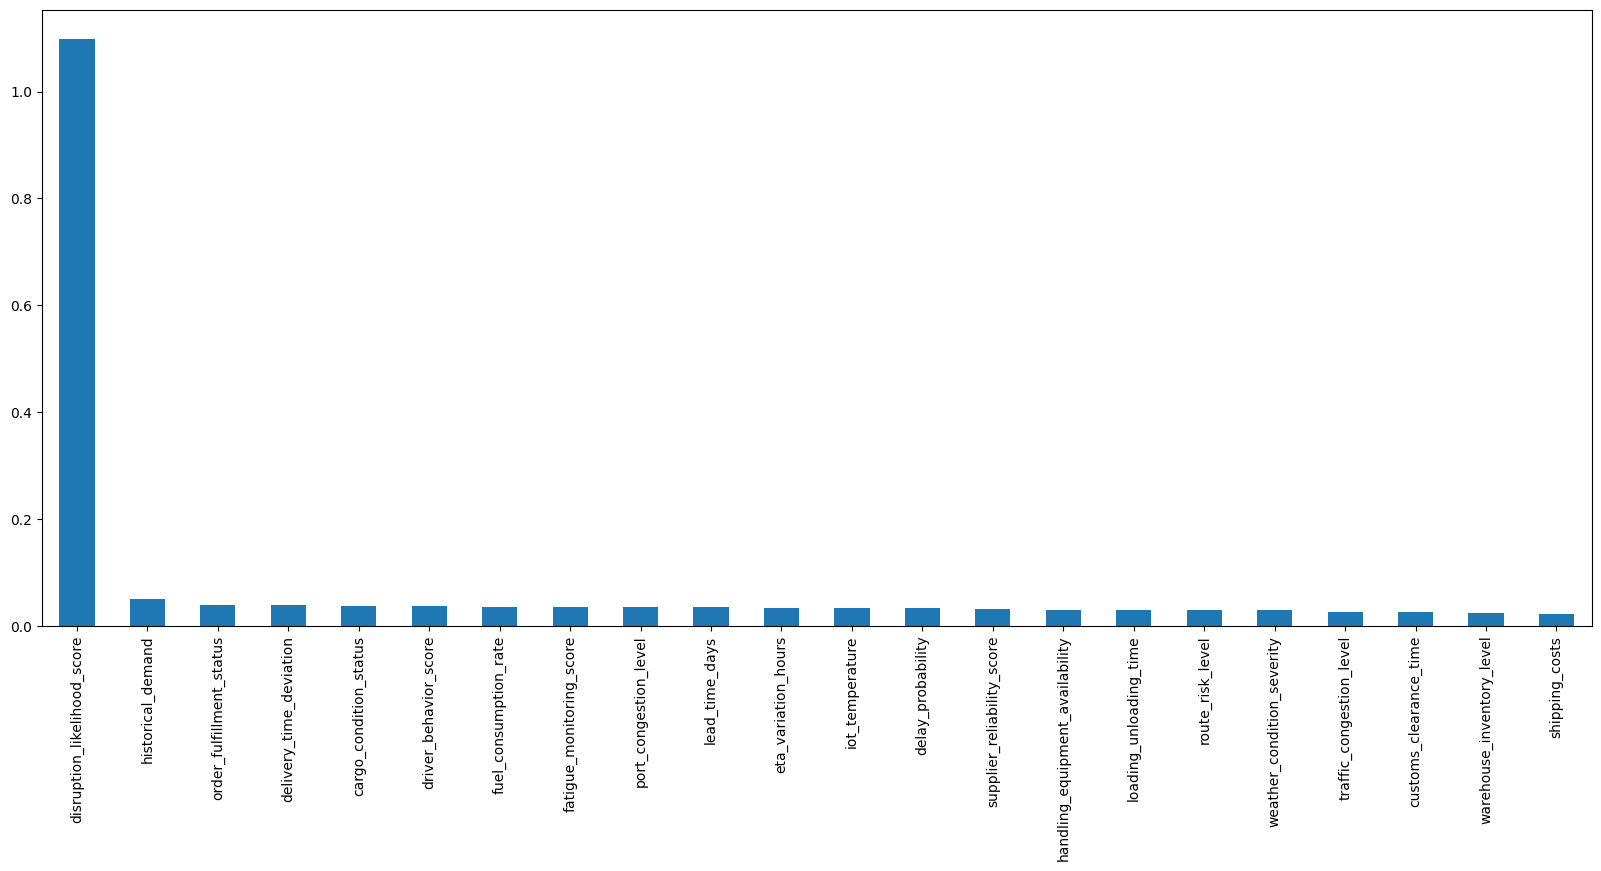

In [18]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [19]:
from sklearn.feature_selection import SelectKBest

#No we Will select the  top 5 important features
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(X_train, y_train)
selected_feature = X_train.columns[sel_five_cols.get_support()]
print(f"Top 5 Feature: {selected_feature}")

Top 5 Feature: Index(['order_fulfillment_status', 'historical_demand',
       'cargo_condition_status', 'disruption_likelihood_score',
       'delivery_time_deviation'],
      dtype='object')


In [20]:
X_train = X_train[selected_feature]
X_test = X_test[selected_feature]

X_train

,order_fulfillment_status,historical_demand,cargo_condition_status,disruption_likelihood_score,delivery_time_deviation
24481,0.882777,7205.246476,0.035134,1.000000,2.348545
58434,0.247370,7995.285807,0.594477,0.562096,8.768822
22492,0.756477,9932.483769,0.477842,0.776728,9.828261
39689,0.318124,9957.979009,0.194927,0.268893,7.516259
2888,0.916517,2104.904816,0.722561,0.999998,1.697481
...,...,...,...,...,...
54343,0.461909,9966.174332,0.076690,0.487871,6.648762
38158,0.930660,4601.759031,0.754161,0.292436,-0.352302
860,0.632656,8251.035573,0.217659,0.953890,3.389473
15795,0.853349,9967.005582,0.937680,0.999965,9.107156


In [21]:
# Transform data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)
X_test_scaled = scaler.transform(X_test)

[[0.88277692 0.71770158 0.03513418 0.9999999  0.36237853]
 [0.24736903 0.79750356 0.59447666 0.42515965 0.89740183]
 [0.7564762  0.99318018 0.47784152 0.70690859 0.98568843]
 ...
 [0.6326551  0.82333687 0.21765886 0.9394711  0.4491226 ]
 [0.85334865 0.99666723 0.93767998 0.99995409 0.9255963 ]
 [0.6650766  0.73330631 0.01289791 0.14487667 0.67038991]]


In [22]:
# code your own model from now on ....

In [23]:
# use from scratch

In [24]:
class Neuron:
    def __init__(self, input_dim, output_dim, activation=None):
        self.W = np.random.randn(input_dim, output_dim) # Generate weight with shape INPUT x OUTPUT (in this case 11 x 5 for the first part and 5 x 2 for the second part)
        self.b = np.random.randn(1, output_dim) # Generate bias in the same shape as the output
        self.activation = activation

    def forward(self, X):
        self.X = X
        self.Z = np.dot(X, self.W) # Input(1 x X) • Weight (X x Y) => Output (1 x Y)
        self.Z += self.b # Add bias to the output
        # Pass the output to the activation function if we have it
        if self.activation:
            self.A = self.activation.forward(self.Z)
        else:
            self.A = self.Z
        return self.A

    def backward(self, dA):
        # Calculate gradient according to loss received by backward propagation
        if self.activation:
            dZ = self.activation.backward(self.Z, dA)
        else:
            dZ = dA
        dW = np.dot(self.X.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True)
        dX = np.dot(dZ, self.W.T)
        return dW, db, dX

class Model:
    def __init__(self, layers_dim, activations):
        self.layers = []
        input_dim = layers_dim[0]
        # for output_dim, activation in zip(layers_dim[:-1], activations[:-1]):
        #     self.layers.append(Neuron(input_dim, output_dim, activation=activation))
        #     input_dim = output_dim
        self.layers.append(Neuron(input_dim, layers_dim[-1], activation=activations[-1]))  # Last layer activation
        self.loss = []

    def calculate_loss(self, X, y):
      # Compute logits (before softmax)
      logits = self.predict(X)

      # Convert logits to probabilities using softmax
      exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
      probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

      # Compute cross-entropy loss
      n_samples = y.shape[0]
      correct_log_probs = -np.log(probs[range(n_samples), y])
      loss = np.sum(correct_log_probs) / n_samples
      return loss

    def predict(self, X):
        # Pass the input into hidden layers and propagate forward in neural network
        input = X
        for layer in self.layers:
            input = layer.forward(input)
        # the result here is passed through all the hidden layers
        return np.argmax(input, axis=1)

    def train(self, X, y, epoch=20000, learning_rate=0.01, print_loss=False):
        batch_size = 500

        # begin training loop
        for epoch in range(epoch):

            # Create Batch using Dataloader
            train_dataset = TensorDataset(X, y)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # Train in batches
            for batch_X, batch_y in train_loader:
              # Forward propagation
              input = batch_X
              for layer in self.layers:
                  input = layer.forward(input)

              # Compute softmax
              exp_logits = np.exp(input - np.max(input, axis=1, keepdims=True))
              probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

              # Compute loss (cross-entropy)
              n_samples = batch_y.shape[0]
              correct_log_probs = -np.log(probs[range(n_samples), batch_y])
              loss = np.sum(correct_log_probs) / n_samples
              self.loss.append(loss)

              # print("check prob:")
              # print(probs)

              # Compute Accuracy
              predictions = np.argmax(probs, axis=1)  # Get predicted class indices
              # print("check predictions:")
              # print(predictions)

              accuracy = (predictions == batch_y).sum() / n_samples # Compare with true labels
              # print("check accuracy:")
              # print(accuracy)

              # Backpropagation (softmax gradient)
              dA = probs
              dA[range(n_samples), batch_y] -= 1  # Gradient of softmax + cross-entropy
              dA /= n_samples

              for layer in reversed(self.layers):
                  dW, db, dA = layer.backward(dA)
                  layer.W -= learning_rate * dW
                  layer.b -= learning_rate * db

            if print_loss and epoch % 10 == 0:
                print(f"Loss after iteration {epoch}: {loss:.6f}, Accuracy = {accuracy:.2%}")


In [25]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Use long for classification
y_val_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Using it in our architecture 5 -> 3
layers_dim = [X_train_tensor.shape[1], 3]  # Input size: 5, No Hidden layer, Output size: 3
activations = [None]


model_SLP = Model(layers_dim, activations)

# y_train_one_hot = np.zeros((y_train_tensor.shape[0], 3), dtype=int)
# y_train_one_hot[np.arange(y_train_tensor.shape[0]), y_train_tensor] = 1
# print(y_train_tensor)
# print(y_train_one_hot)

model_SLP.train(X_train_tensor, y_train_tensor, epoch=100, learning_rate=0.1, print_loss=True)

# save model
joblib.dump(model_SLP, 'model_SLP.joblib')

<ipython-input-24-bd162a28a019>:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  self.Z = np.dot(X, self.W) # Input(1 x X) • Weight (X x Y) => Output (1 x Y)
<ipython-input-24-bd162a28a019>:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dW = np.dot(self.X.T, dZ)


Loss after iteration 0: 0.924206, Accuracy = 57.14%
Loss after iteration 10: 0.435291, Accuracy = 92.86%
Loss after iteration 20: 0.331256, Accuracy = 100.00%
Loss after iteration 30: 0.281638, Accuracy = 100.00%
Loss after iteration 40: 0.301428, Accuracy = 92.86%
Loss after iteration 50: 0.299565, Accuracy = 92.86%
Loss after iteration 60: 0.184861, Accuracy = 100.00%
Loss after iteration 70: 0.115159, Accuracy = 100.00%
Loss after iteration 80: 0.130034, Accuracy = 100.00%
Loss after iteration 90: 0.223671, Accuracy = 92.86%


['model_SLP.joblib']

In [26]:
# load model to use for evaluation
path_to_model = './model_SLP.joblib'
model_SLP_loaded = joblib.load(path_to_model)
y_pred = model_SLP_loaded.predict(X_val_tensor)

<ipython-input-24-bd162a28a019>:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  self.Z = np.dot(X, self.W) # Input(1 x X) • Weight (X x Y) => Output (1 x Y)


In [27]:
# Begin Evaluation (classification)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Classification Report
print("classification report : ")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix : ")
print(cm)

classification report : 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5011
           1       0.94      1.00      0.97      5181
           2       0.98      0.93      0.95      5147

    accuracy                           0.97     15339
   macro avg       0.97      0.97      0.97     15339
weighted avg       0.97      0.97      0.97     15339

Confusion Matrix : 
[[4893    0  118]
 [   0 5181    0]
 [   1  343 4803]]


In [28]:
# Precision, Recall (Sensitivity), and F1-score for multiclass
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")  # Precision (average the results across all classes)
recall = recall_score(y_test, y_pred, average="macro")  # Sensitivity (average the results across all classes)
f1 = f1_score(y_test, y_pred, average="macro")  # F1-score (average the results across all classes)

# Compute Specificity for each class
specificity_list = []
for i in range(len(cm)):
    TP = cm[i, i]
    FN = sum(cm[i, :]) - TP
    FP = sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    specificity_list.append(specificity)

specificity_macro = np.mean(specificity_list)  # Macro-averaged specificity

# Metrics (averages scores equally across all classes)
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision (Macro): {precision:.4f}')
print(f'Sensitivity (Recall, Macro): {recall:.4f}')
print(f'Specificity (Macro): {specificity_macro:.4f}')
print(f'F1-Score (Macro): {f1:.4f}')

Accuracy : 0.9699
Precision (Macro): 0.9712
Sensitivity (Recall, Macro): 0.9699
Specificity (Macro): 0.9849
F1-Score (Macro): 0.9700


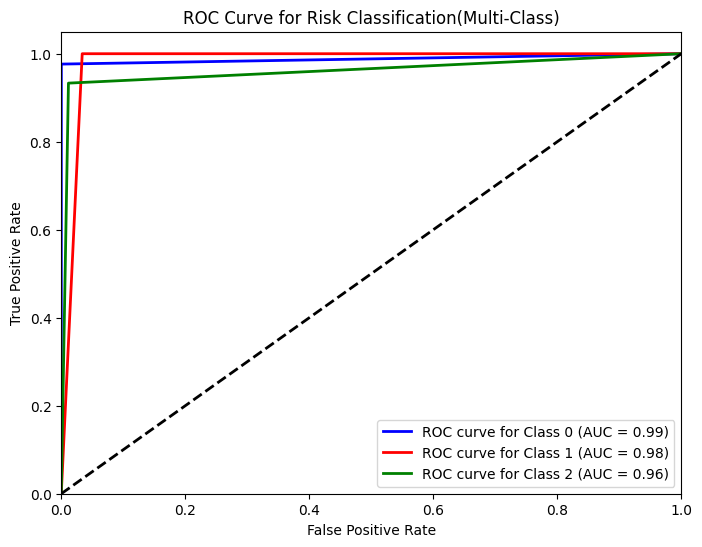

In [29]:
# Compute ROC curve and ROC AUC for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC
# In the case of multiclass classification, a notion of TPR or FPR is obtained only after binarizing the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

n_classes = y_test_bin.shape[1]
# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve for Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Risk Classification(Multi-Class)')
plt.legend(loc="lower right")
plt.show()